<h1 align='center'>AutoSynthesis study group</h1>
<h2 align='center'> Session 4 - Model assessment and performance improvement </h2>
<h3 align='right'> 14th March 2019 </h3>
<h3 align='right'> Kazeem </h3>

### Load libraries

In [1]:
print(__doc__)
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


print ('Packages import successful')

Automatically created module for IPython interactive environment
Packages import successful


### Load your dataset

In [4]:
data = pd.read_csv('autosynthesis_session3.csv') #set the data path relative to your system and file location
print ('Dataset loaded successfully')
data.head(5) #view some samples

le = LabelEncoder()
data['labels'] = le.fit_transform(data['label'])
data['TiAbs'] = data[['Title', 'Abstract', 'Keywords']].apply(lambda x: '{} {} {}'.format(x[0], x[1], x[2]), axis=1)
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['TiAbs'], data['label'], test_size=0.10, random_state=19)

Dataset loaded successfully


### preprocessing

In [5]:
#optionally write custom preprocessing method.....WHY?
def preprocessor(text):
    #text = text.apply(lambda x: ' '.join(x.lower().replace('[^\w\s]','') for x in str(x).split() if not x in set(stopwords.words('english')) and not x.isdigit()))
    
    # split into words
    from nltk.tokenize import word_tokenize
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    #from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words and len(w) > 3]
    
    return ' '.join(words) #return the cleaned text string separated by spaces

#### Data cleaning and tokenization

In [6]:
X_train = X_train.apply(lambda x: preprocessor(x))
X_test = X_test.apply(lambda x: preprocessor(x))

#from sklearn.feature_extraction.text import TfidfVectorizer
binary_encoder = TfidfVectorizer(stop_words='english', binary = True, max_df=0.8, min_df=3, ngram_range=(1, 1))
binary_train_data = binary_encoder.fit_transform(X_train)
binary_test_data = binary_encoder.transform(X_test)

#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
tfidf_train_data = tfidf_encoder.fit_transform(X_train)
tfidf_test_data = tfidf_encoder.transform(X_test)

### Fit a model

#### A. Binary features

In [7]:
gnb = GaussianNB()
bnb = BernoulliNB(binarize = None)#if dataset is already in binary form
mnb = MultinomialNB()
cnb = ComplementNB()
svm = SVC(C = 10, kernel = 'linear', class_weight=None, gamma = 'scale', random_state=None)


#train mmodel using training data
gnb_model = gnb.fit(binary_train_data.toarray(), y_train)
print ('Done fitting Gaussian NB model')
bnb_model = bnb.fit(binary_train_data.toarray(), y_train)
print ('Done fitting Bernoulli NB model')
mnb_model = mnb.fit(binary_train_data.toarray(), y_train)
print ('Done fitting Multinomial NB model')
cnb_model = cnb.fit(binary_train_data.toarray(), y_train)
print ('Done fitting Complement NB model')
svm_model = svm.fit(binary_train_data.toarray(), y_train)
print ('Done fitting SVM model')

print ('------------------------------------------------------------------------ \n')
print ('Finished fitting all models')
print ('Trained models ready for prediction on new data \n')
print ('------------------------------------------------------------------------ \n')

#use each model to predict on new data
gnb_prediction = gnb_model.predict(binary_test_data.toarray())
print ('Done predicting with Gaussian NB model')
bnb_prediction = bnb_model.predict(binary_test_data.toarray())
print ('Done predicting with Bernoulli NB model')
mnb_prediction = mnb_model.predict(binary_test_data.toarray())
print ('Done predicting with Multinomial NB model')
cnb_prediction = cnb_model.predict(binary_test_data.toarray())
print ('Done predicting with Complement NB model')
svm_prediction = svm_model.predict(binary_test_data.toarray())
print ('Done predicting with SVM model')

Done fitting Gaussian NB model
Done fitting Bernoulli NB model
Done fitting Multinomial NB model
Done fitting Complement NB model
Done fitting SVM model
------------------------------------------------------------------------ 

Finished fitting all models
Trained models ready for prediction on new data 

------------------------------------------------------------------------ 

Done predicting with Gaussian NB model
Done predicting with Bernoulli NB model
Done predicting with Multinomial NB model
Done predicting with Complement NB model
Done predicting with SVM model


## Model assessment

#### Some basic metrics

In [8]:
#from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
accuracy = accuracy_score(y_test, cnb_prediction)
precision = precision_score(y_test, cnb_prediction, average= 'micro')
recall = recall_score(y_test, cnb_prediction, average= 'micro')
confusion_matrix(y_test, cnb_prediction)
print(classification_report(y_test, cnb_prediction, target_names=['Yes', 'No']))

              precision    recall  f1-score   support

         Yes       0.88      1.00      0.93        42
          No       1.00      0.14      0.25         7

   micro avg       0.88      0.88      0.88        49
   macro avg       0.94      0.57      0.59        49
weighted avg       0.89      0.88      0.84        49



#### Inspect how each model classified

In [9]:
print ('Guassian NB model: \n')
pd.crosstab(gnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Guassian NB model: 



Predicted,N,Y,All
Actual,,,
N,42,7,49
All,42,7,49


In [10]:
print ('Bernoulli NB model: \n')
pd.crosstab(bnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Bernoulli NB model: 



Predicted,N,Y,All
Actual,,,
N,42,7,49
All,42,7,49


In [11]:
print ('Multinomial NB model: \n')
pd.crosstab(mnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Multinomial NB model: 



Predicted,N,Y,All
Actual,,,
N,42,7,49
All,42,7,49


In [12]:
print ('Complement NB model: \n')
pd.crosstab(cnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Complement NB model: 



Predicted,N,Y,All
Actual,,,
N,42,6,48
Y,0,1,1
All,42,7,49


In [13]:
print ('SVM model: \n')
pd.crosstab(svm_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

SVM model: 



Predicted,N,Y,All
Actual,,,
N,42,4,46
Y,0,3,3
All,42,7,49


In [14]:
# add the predictions to dataframe for comparision with true label
test_data = X_test
test_data = pd.DataFrame(test_data)

test_data['Article_ID'] = pd.DataFrame(data.iloc[list(test_data.index.values), 0])
test_data['true label'] = y_test
test_data['bnb_binary'] = gnb_prediction
test_data['bnb_binary'] = bnb_prediction
test_data['mnb_binary'] = mnb_prediction
test_data['cnb_binary'] = cnb_prediction
test_data['svm_binary'] = svm_prediction

#### B. tfidf features

In [15]:
gnb = GaussianNB()
bnb = BernoulliNB()#if dataset is already in binary form
mnb = MultinomialNB()
cnb = ComplementNB()
svm = SVC(C = 10, kernel = 'linear', class_weight=None, gamma = 'scale', random_state=None)


#train mmodel using training data
gnb_model = gnb.fit(tfidf_train_data.toarray(), y_train)
print ('Done fitting Gaussian NB model')
bnb_model = bnb.fit(tfidf_train_data.toarray(), y_train)
print ('Done fitting Bernoulli NB model')
mnb_model = mnb.fit(tfidf_train_data.toarray(), y_train)
print ('Done fitting Multinomial NB model')
cnb_model = cnb.fit(tfidf_train_data.toarray(), y_train)
print ('Done fitting Complement NB model')
svm_model = svm.fit(tfidf_train_data, y_train)
print ('Done fitting SVM model')

#use model to predict on new data
gnb_prediction = gnb_model.predict(tfidf_test_data.toarray())
bnb_prediction = bnb_model.predict(tfidf_test_data.toarray())
mnb_prediction = mnb_model.predict(tfidf_test_data.toarray())
cnb_prediction = cnb_model.predict(tfidf_test_data.toarray())
svm_prediction = svm_model.predict(tfidf_test_data)

Done fitting Gaussian NB model
Done fitting Bernoulli NB model
Done fitting Multinomial NB model
Done fitting Complement NB model
Done fitting SVM model


In [16]:
#from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
accuracy = accuracy_score(y_test, svm_prediction)
precision = precision_score(y_test, svm_prediction, average= 'micro')
recall = recall_score(y_test, svm_prediction, average= 'micro')
confusion_matrix(y_test, svm_prediction)

print ('SVM RESULT ........')
print ('Accuracy: ', accuracy)
print('PRECISION: ', precision)
print('RECALL: ', recall)
print(classification_report(y_test, svm_prediction, target_names=['Yes', 'No']))

SVM RESULT ........
Accuracy:  0.9183673469387755
PRECISION:  0.9183673469387755
RECALL:  0.9183673469387755
              precision    recall  f1-score   support

         Yes       0.91      1.00      0.95        42
          No       1.00      0.43      0.60         7

   micro avg       0.92      0.92      0.92        49
   macro avg       0.96      0.71      0.78        49
weighted avg       0.93      0.92      0.90        49



#### Inspect how each model classified

In [17]:
print ('Guassian NB model: \n')
pd.crosstab(gnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Guassian NB model: 



Predicted,N,Y,All
Actual,,,
N,42,6,48
Y,0,1,1
All,42,7,49


In [18]:
print ('Bernoulli NB model: \n')
pd.crosstab(bnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Bernoulli NB model: 



Predicted,N,Y,All
Actual,,,
N,42,5,47
Y,0,2,2
All,42,7,49


In [19]:
print ('Multinomial NB model: \n')
pd.crosstab(mnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Multinomial NB model: 



Predicted,N,Y,All
Actual,,,
N,42,7,49
All,42,7,49


In [20]:
print ('Complement NB model: \n')
pd.crosstab(cnb_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

Complement NB model: 



Predicted,N,Y,All
Actual,,,
N,42,6,48
Y,0,1,1
All,42,7,49


In [21]:
print ('SVM model: \n')
pd.crosstab(svm_prediction, y_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

SVM model: 



Predicted,N,Y,All
Actual,,,
N,42,4,46
Y,0,3,3
All,42,7,49


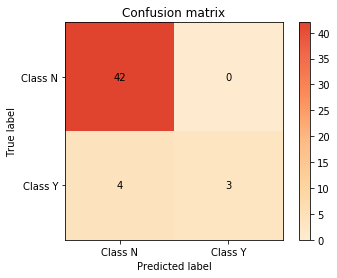

In [22]:
#Alternative confusion matrix visualization
from sklearn_evaluation import plot
y_pred = svm_model.predict(tfidf_test_data)
plot.confusion_matrix(y_test, y_pred)
plt.show()

In [23]:
#add the predictions to dataframe
test_data['gnb_tfidf'] = gnb_prediction
test_data['bnb_tfidf'] = bnb_prediction
test_data['mnb_tfidf'] = mnb_prediction
test_data['cnb_tfidf'] = cnb_prediction
test_data['svm_tfidf'] = svm_prediction

In [25]:
#View the predictions alongside true label
test_data.iloc[0:, 1:]

,Article_ID,true label,bnb_binary,mnb_binary,cnb_binary,svm_binary,gnb_tfidf,bnb_tfidf,mnb_tfidf,cnb_tfidf,svm_tfidf
181,182,N,N,N,N,N,N,N,N,N,N
37,38,N,N,N,N,N,N,N,N,N,N
10,11,N,N,N,N,N,N,N,N,N,N
411,430,N,N,N,N,N,N,N,N,N,N
468,487,N,N,N,N,N,N,N,N,N,N
185,186,N,N,N,N,N,N,N,N,N,N
320,338,N,N,N,N,N,N,N,N,N,N
317,335,N,N,N,N,N,N,N,N,N,N
387,407,N,N,N,N,N,N,N,N,N,N
190,191,N,N,N,N,N,N,N,N,N,N


## Feature selection 

#### A. Chi square

In [27]:
#build feature representation models for binary and tfidf
binary_encoder = TfidfVectorizer(stop_words='english', binary = True, max_df=0.8, min_df=3, ngram_range=(1, 1))
binary_train_data = binary_encoder.fit_transform(X_train)
binary_test_data = binary_encoder.transform(X_test)
bin_words = binary_encoder.get_feature_names()
bin_words = np.asarray(bin_words)
BoW =np.vstack((bin_words, binary_train_data.toarray()))
bin_df = pd.DataFrame(data=BoW[1:,:], columns = BoW[0,:])

#from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
tfidf_train_data = tfidf_encoder.fit_transform(X_train)
tfidf_test_data = tfidf_encoder.transform(X_test)
tf_words = tfidf_encoder.get_feature_names()
tf_words = np.asarray(tf_words)
BoW =np.vstack((tf_words, tfidf_train_data.toarray()))
tf_df = pd.DataFrame(data=BoW[1:,:], columns = BoW[0,:])


In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)#chi square method
fit = bestfeatures.fit(binary_train_data,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(bin_df.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['bin_Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

        bin_Features     Score
2849        workload  6.488218
2282         reviews  5.843619
2622            text  5.490333
6          abstracts  3.947142
386        citations  3.746860
2652   timeconsuming  3.566376
2365  semiautomation  3.500896
2333       screening  3.350825
4           abstract  3.256562
229       automating  3.085455
2842            word  3.036094
385         citation  2.930382
734     dictionaries  2.901794
1296        indexing  2.817143
2659          titles  2.676281
2112          rayyan  2.667198
2571        synonyms  2.657469
1629          mining  2.549996
1425       judgments  2.407611
2307         savings  2.356085


In [29]:
fit = bestfeatures.fit(tfidf_train_data,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(tf_df.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['tf_Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

       tf_Features      Score
2333     screening  14.349404
2282       reviews  13.347484
386      citations  10.738390
2622          text   9.426330
2849      workload   8.675663
2577    systematic   8.204689
2112        rayyan   7.077964
6        abstracts   5.890301
626       curation   4.198098
1629        mining   4.043727
385       citation   3.854103
850       elements   3.831236
415     clustering   3.805039
2842          word   3.291819
4         abstract   3.179642
2164    references   2.978691
2201      relevant   2.832707
2611      temporal   2.752041
206   associations   2.649581
2666         topic   2.617536


#### B. Tree classification

[0. 0. 0. ... 0. 0. 0.]


C:\Users\ja18581\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


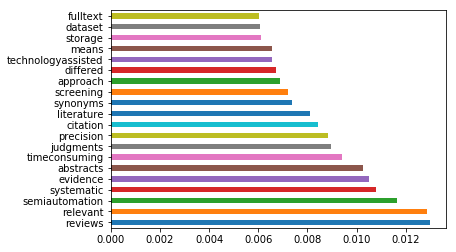

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X = data['TiAbs'].apply(lambda x: preprocessor(x))
tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
y = data['label']
X = tfidf_encoder.fit_transform(X)
tf_words = tfidf_encoder.get_feature_names()
tf_words = np.asarray(tf_words)
BoW =np.vstack((tf_words, X.toarray()))
tf_df = pd.DataFrame(data=BoW[1:,:], columns = BoW[0,:])

model = ExtraTreesClassifier()#tree classifer model
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=tf_df.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

### Classification with selected features

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data['TiAbs'], data['label'], test_size=0.10, random_state=19)

In [32]:
#from sklearn.feature_extraction.text import TfidfVectorizer
binary_encoder = TfidfVectorizer(stop_words='english', binary = True, max_df=0.8, min_df=3, ngram_range=(1, 1))
binary_train_data = binary_encoder.fit_transform(X_train)
binary_test_data = binary_encoder.transform(X_test)

tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
tfidf_train_data = tfidf_encoder.fit_transform(X_train)
tfidf_test_data = tfidf_encoder.transform(X_test)

In [33]:
bestfeatures = SelectKBest(score_func=chi2, k=20)
chi_data = bestfeatures.fit_transform(binary_train_data,y_train)
tf_train = bestfeatures.fit_transform(tfidf_train_data,y_train)
chi_test = bestfeatures.fit_transform(binary_test_data,y_test)
tf_test = bestfeatures.fit_transform(tfidf_test_data,y_test)

In [34]:
#train mmodel using training data
bnb_model = bnb.fit(chi_data.toarray(), y_train)
print ('Done fitting Bernoulli NB model')
cnb_model = cnb.fit(chi_data.toarray(), y_train)
print ('Done fitting Complement NB model')
svm_model = svm.fit(chi_data.toarray(), y_train)
print ('Done fitting SVM model')

print ('------------------------------------------------------------------------ \n')
print ('Finished fitting all models')
print ('Trained models ready for prediction on new data \n')
print ('------------------------------------------------------------------------ \n')

#use each model to predict on new data
bnb_prediction = bnb_model.predict(chi_test.toarray())
print ('Done predicting with Bernoulli NB model')
cnb_prediction = cnb_model.predict(chi_test.toarray())
print ('Done predicting with Complement NB model')
svm_prediction = svm_model.predict(chi_test.toarray())
print ('Done predicting with SVM model')

Done fitting Bernoulli NB model
Done fitting Complement NB model
Done fitting SVM model
------------------------------------------------------------------------ 

Finished fitting all models
Trained models ready for prediction on new data 

------------------------------------------------------------------------ 

Done predicting with Bernoulli NB model
Done predicting with Complement NB model
Done predicting with SVM model


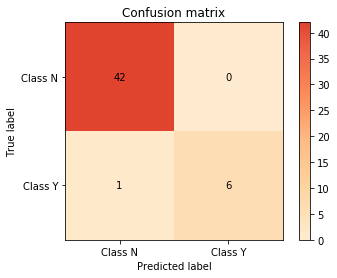

In [36]:
y_pred = bnb_model.predict(chi_test)
plot.confusion_matrix(y_test, y_pred)
plt.show()

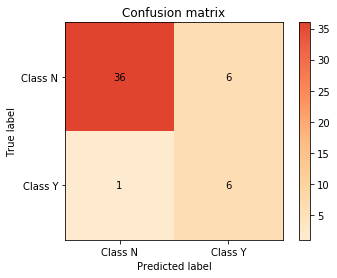

In [35]:
y_pred = cnb_model.predict(chi_test)
plot.confusion_matrix(y_test, y_pred)
plt.show()

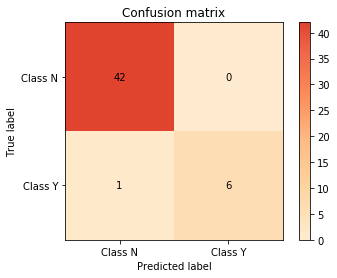

In [38]:
y_pred = svm_model.predict(chi_test.toarray())
plot.confusion_matrix(y_test, y_pred)
plt.show()

In [39]:
bnb_model = bnb.fit(tf_train.toarray(), y_train)
print ('Done fitting Bernoulli NB model')
cnb_model = cnb.fit(tf_train.toarray(), y_train)
print ('Done fitting Complement NB model')
svm_model = svm.fit(tf_train, y_train)
print ('Done fitting SVM model')

#use model to predict on new data
bnb_prediction = bnb_model.predict(tf_test.toarray())
cnb_prediction = cnb_model.predict(tf_test.toarray())
svm_prediction = svm_model.predict(tf_test)

Done fitting Bernoulli NB model
Done fitting Complement NB model
Done fitting SVM model


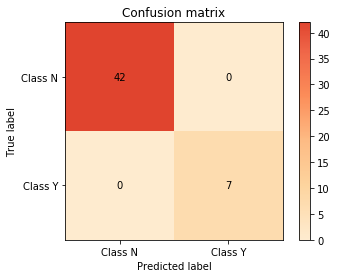

In [44]:
y_pred = bnb_model.predict(tf_test)
plot.confusion_matrix(y_test, y_pred)
plt.show()

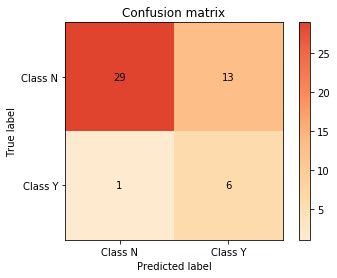

In [41]:
y_pred = cnb_model.predict(tf_test)
plot.confusion_matrix(y_test, y_pred)
plt.show()

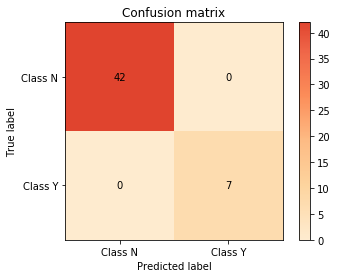

In [43]:
y_pred = svm_model.predict(tf_test)
plot.confusion_matrix(y_test, y_pred)
plt.show()

### Learning rate inspection with learning curves 

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

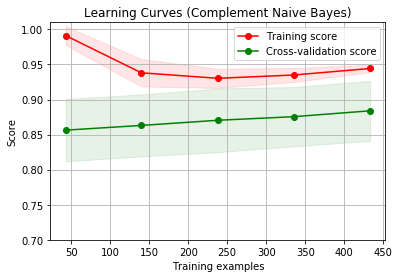

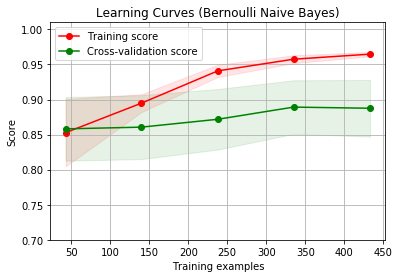

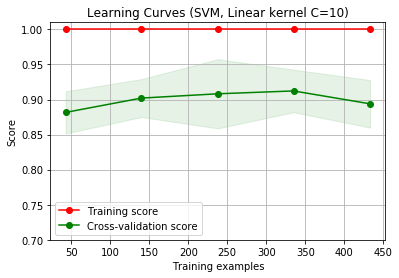

In [50]:
X = data['TiAbs'].apply(lambda x: preprocessor(x))

tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
y = data['label']
X = tfidf_encoder.fit_transform(X)

title = "Learning Curves (Complement Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = ComplementNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Bernoulli Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = BernoulliNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


title = "Learning Curves (SVM, Linear kernel C=10)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = SVC(C = 10, kernel = 'linear')
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

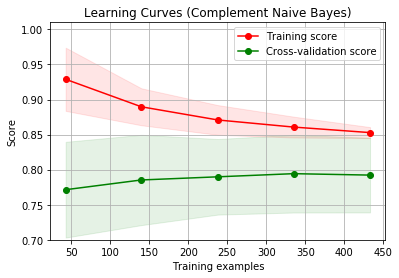

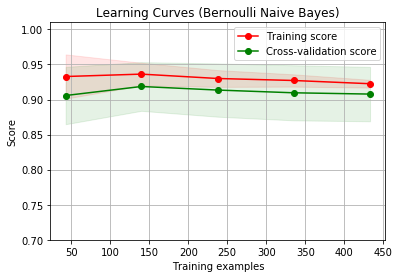

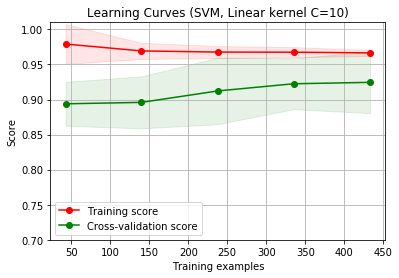

In [63]:
bestfeatures = SelectKBest(score_func=chi2, k=100)
X = data['TiAbs'].apply(lambda x: preprocessor(x))

tfidf_encoder = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=3, ngram_range=(1, 1))
y = data['label']
X = bestfeatures.fit_transform(tfidf_encoder.fit_transform(X), y)

title = "Learning Curves (Complement Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = ComplementNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Bernoulli Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.1, random_state=0)

estimator = BernoulliNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)


title = "Learning Curves (SVM, Linear kernel C=10)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
estimator = SVC(C = 10, kernel = 'linear')
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()